TODO: 

add some plotting

add way to determine clustering linkage distances

clean up later modules

put cluster selection into module

make cluster selection work with sparse inputs

chase down memory usage in cluster selection

# Setup

In [93]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: rich_clust
python version: 3.9.12


In [2]:
import os
from pathlib import Path
import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt
import numpy as np
import sklearn.manifold
import sklearn.cluster
import seaborn as sns
import pandas as pd
import sparse
import cv2
import natsort

import torch
from kymatio.torch import Scattering2D

import gc
from tqdm.notebook import tqdm
import copy
import time
import random
import functools
import multiprocessing as mp


In [3]:
params = {
    'dir_github': r'/media/rich/Home_Linux_partition/github_repos/',
    'dir_allOuterFolders': r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10",
    'pathSuffixToStat': 'plane1/stat.npy',
    'pathSuffixToOps': 'plane1/ops.npy',
    'pref_use_NN_distances': True,
    'use_GPU': True,
    'pref_blurROIs': True,
    'params_blur': {
        'kernel_size': 7, # Edge length of kernel image. Make odd number.
        'kernel_width': 2.1, # width of 1 full cosine cycle for the 2d cosine kernel. Use width=2 for a single pixel.
    },
    'mask_power': 1, ## This parameter determines how 'binary'-looking masks are. Small values = more binary. Large values weight bright pixels more. mask_scaled = mask**mask_power
    'params_dIOU': {
        'algorithm': 'brute', ## Can be 'brute', 'auto', or anything from sklearn.neighbors.NearestNeighbors
        'n_neighbors': 'full', ## Can either be an int or 'full', in which case the output will not be sparse
    }
}

In [4]:
dir_github = Path(params['dir_github']).resolve()

import sys
sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import path_helpers, torch_helpers, featurization, indexing, misc, torch_helpers, plotting_helpers, classification, math_functions, parallel_helpers, clustering, image_processing, pickle_helpers, container_helpers

In [5]:
device = torch_helpers.set_device(use_GPU=params['use_GPU'])

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24234MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24234MB, multi_processor_count=82)


In [6]:
%load_ext autoreload
%autoreload 2
from registration_rClust import data_importing, visualization, alignment, blurring, helpers, ROInet, scatteringWaveletTransformer, similarity_graph, cluster_assignment

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
%matplotlib notebook

# Import paths

In [8]:
def print_list(l):
    for item in l:
        print(item)

In [9]:
dir_allOuterFolders = Path(params['dir_allOuterFolders']).resolve()

folders_allSessions = natsort.natsorted(path_helpers.get_dir_contents(dir_allOuterFolders)[0])

folders_toUse = folders_allSessions
# folders_toUse = list(map(folders_allSessions.__getitem__, [np.arange(1,9, dtype=np.int32)]))


# dir_allS2pFolders = [dir_allOuterFolders / folder / 'exp' / 'suite2p' / 'plane0' for folder in folders_toUse]
dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_toUse]

pathSuffixToStat = params['pathSuffixToStat']
pathSuffixToOps = params['pathSuffixToOps']

paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])[:2]
paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])[:2]

print(folders_allSessions)
print(folders_toUse)
print_list(dir_allS2pFolders)
print_list(paths_allStat)

['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14']
['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14']
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D1
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D2
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D3
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D4
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D5
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D6
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10/D7
/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Vale

# Import data

In [10]:
data = data_importing.Data_suite2p(
    paths_statFiles=paths_allStat,
    paths_opsFiles=paths_allOps,
    verbose=True,
)

In [11]:
data.import_statFiles();

data.import_ROI_centeredImages(
    out_height_width=[36, 36],
    max_footprint_width=1025,
);

data.import_FOV_images(
    type_meanImg='meanImgE',
    images=None
);

data.import_ROI_spatialFootprints(workers=-1);

Imported 2 stat files into class as self.statFiles. Total number of ROIs: 5249. Number of ROI from each file: [2451, 2798]


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.85it/s]

Converted 2 spatial footprint files into small centered images in self.ROI_images.


Imported 2 FOV images into class as self.FOV_images
Imported 2 sessions of spatial footprints into sparse arrays.


In [12]:
# visualization.display_toggle_image_stack(data.FOV_images)

# Alignment

In [13]:
aligner = alignment.Alinger(
    method='createOptFlow_DeepFlow',
    kwargs_method=None
)

aligner.register_ROIs(
    templateFOV=data.FOV_images[0],
    FOVs=data.FOV_images,
    ROIs=data.spatialFootprints,
    return_sparse=True,
    normalize=True,
);

100%|█████████████████████████████████████████████| 2/2 [00:25<00:00, 12.94s/it]


In [14]:
# visualization.display_toggle_image_stack(aligner.FOVs_aligned)
# visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection())

## Blur ROIs (optional)

In [15]:
blurrer = blurring.ROI_Blurrer(
    frame_shape=(data.FOV_height, data.FOV_width),
    kernel_halfWidth=2.0,
    device='cpu',
    plot_kernel=False
)

blurrer.blur_ROIs(
    spatialFootprints=aligner.ROIs_aligned,
    batch_size=2000,
);

In [16]:
# visualization.display_toggle_image_stack(blurrer.get_ROIsBlurred_maxIntensityProjection())

## Neural network embedding distances

In [17]:
data.ROI_images[0].shape

(2451, 36, 36)

In [18]:
hash_dict_true = {
    'params': ('params.json', '877e17df8fa511a03bc99cd507a54403'),
    'model': ('model.py', '6ef5c29793ae16a64e43e8cab33d9ff4'),
    'state_dict': ('ConvNext_tiny__1_0_unfrozen__simCLR.pth', 'a5fae4c9ea95f2c78b4690222b2928a5'),
}

roinet = ROInet.ROInet_embedder(
    device='cuda:0',
    dir_networkFiles='/home/rich/Downloads/ROInet',
    download_from_gDrive='check_local_first',
    gDriveID='1FCcPZUuOR7xG-hdO6Ei6mx8YnKysVsa8',
    hash_dict_networkFiles=hash_dict_true,
    verbose=True,
)

roinet.generate_dataloader(
    ROI_images=data.ROI_images,
    goal_size=250,
    ptile_norm=90,
    scale_norm=0.6,
    pref_plot=False,
    batchSize_dataloader=8,
    pinMemory_dataloader=True,
    numWorkers_dataloader=mp.cpu_count(),
    persistentWorkers_dataloader=True,
    prefetchFactor_dataloader=2,    
)

roinet.generate_latents();

Successful hash comparison. Found matching files: {'params': '/home/rich/Downloads/ROInet/params.json', 'model': '/home/rich/Downloads/ROInet/model.py', 'state_dict': '/home/rich/Downloads/ROInet/ConvNext_tiny__1_0_unfrozen__simCLR.pth'}
Imported model from /home/rich/Downloads/ROInet/model.py
Loaded params_model from /home/rich/Downloads/ROInet/params.json


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from /home/rich/Downloads/ROInet/ConvNext_tiny__1_0_unfrozen__simCLR.pth
Loaded network onto device cuda:0
Starting: resizing ROIs


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.12it/s]


Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader
starting: running data through network


  0%|                                                   | 0/657 [00:00<?, ?it/s]/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node 

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile informati

completed: running data through network


In [19]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

## Scattering wavelet embedding distances

In [20]:
swt = scatteringWaveletTransformer.SWT(
    kwargs_Scattering2D={'J': 2, 'L': 8}, 
    image_shape=(36,36), 
    device='cuda:0'
)

swt.transform(ROI_images=np.concatenate(data.ROI_images, axis=0));

## Compute similarities

In [139]:
sim = similarity_graph.ROI_graph(
    device='cpu',
    n_workers=-1,
    spatialFootprint_maskPower=0.8,
    frame_height=data.FOV_height,
    frame_width=data.FOV_width,
    block_height=50,
    block_width=50,
    overlapping_width_Multiplier=0.1,
    algorithm_nearestNeigbors_spatialFootprints='brute',
    n_neighbors_nearestNeighbors_spatialFootprints='full',
    locality=1,
    verbose=True,
)

Outer block height not specified. Using 50.0
Outer block width not specified. Using 50.0


<IPython.core.display.Javascript object>


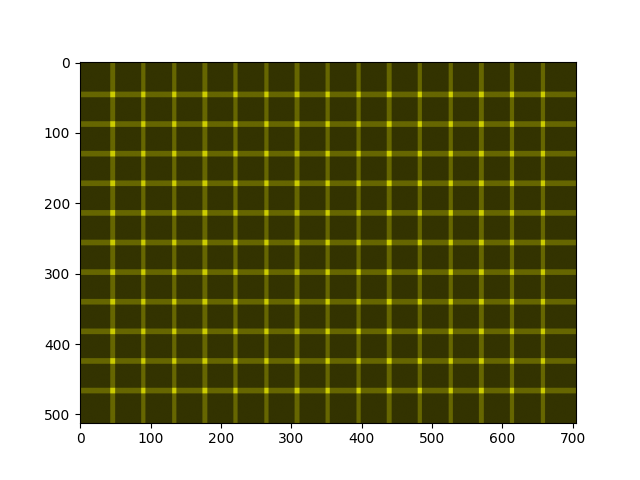

In [140]:
sim.visualize_blocks()

In [145]:
sim.compute_similarity_blockwise(
    spatialFootprints=blurrer.ROIs_blurred,
    features_NN=roinet.latents,
    features_SWT=swt.latents,
    ROI_session_bool=data.sessionID_concat,
    linkage_methods=['single', 'complete', 'ward', 'average'],
    linkage_distances=math_functions.bounded_logspace(0.05, 2, 50),
    min_cluster_size=2,
    max_cluster_size=None,
    batch_size_hashing=300,
);

sim.compute_cluster_similarity_graph(
        cluster_similarity_reduction_intra='mean',
        cluster_similarity_reduction_inter='max',
        cluster_silhouette_reduction_intra='mean',
        cluster_silhouette_reduction_inter='max',
        n_workers=100,
);

sim.compute_cluster_scores(
    power_clusterSize=2, 
    power_clusterSilhouette=1.5
);

100%|█████████████████████████████████████████| 192/192 [01:56<00:00,  1.64it/s]


<IPython.core.display.Javascript object>


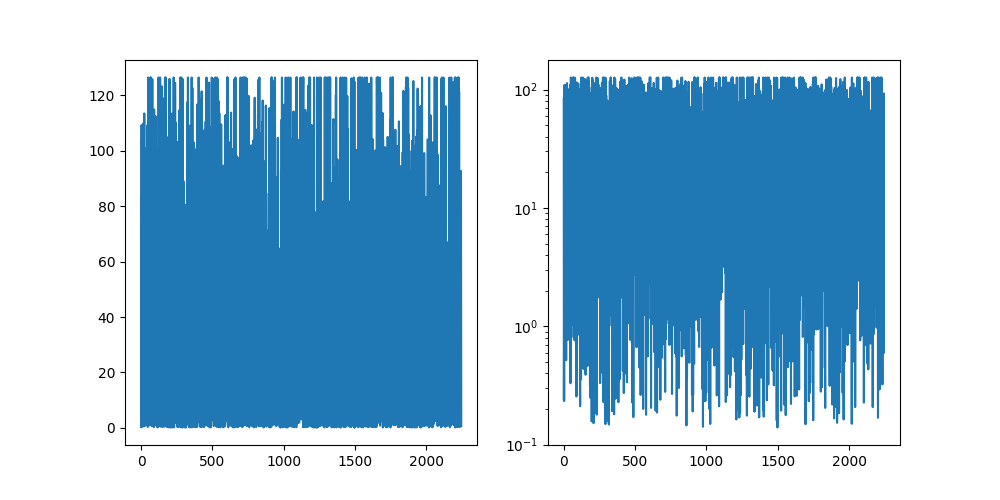

In [218]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].plot(sim.scores.cpu())
# plt.ylim([0,1.1])
axs[1].plot(sim.scores.cpu())
axs[1].set_yscale('log')

<IPython.core.display.Javascript object>


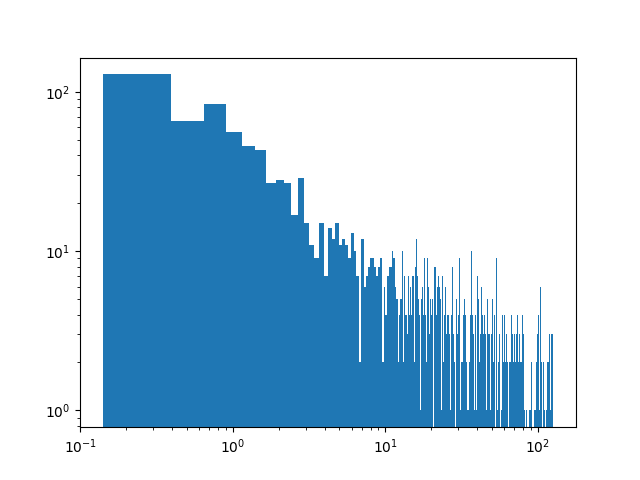

In [219]:
plt.figure()
plt.hist(sim.scores.cpu(), 500)
plt.yscale('log')
plt.xscale('log')

<IPython.core.display.Javascript object>


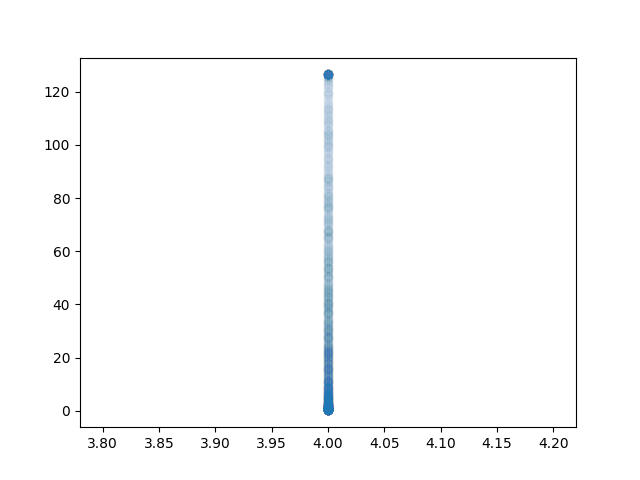

In [98]:
plt.figure()
plt.scatter((np.array(sim.cluster_bool.sum(1)).squeeze()**2), w_raw, alpha=0.01)

In [162]:
clusterAssigner = cluster_assignment.Cluster_Assigner(
    c=sim.c_sim,
    h=sim.cluster_bool.T,
    w=sim.scores,
    device=DEVICE,
    m_init=(torch.ones(c.shape[0])*-5 + torch.rand(c.shape[0])*1).type(torch.float32),
    optimizer_partial=functools.partial(torch.optim.Adam, lr=1e-1, betas=(0.9, 0.900)),
    scheduler_partial=functools.partial(torch.optim.lr_scheduler.CyclicLR, base_lr=1e-3, max_lr=3e0, step_size_up=250, cycle_momentum=False, verbose=False),
    dmCEL_temp=1,
    dmCEL_sigSlope=2,
    dmCEL_sigCenter=0.5,
    dmCEL_penalty=1e0,
    sampleWeight_softplusKwargs={'beta': 500, 'threshold': 50},
    sampleWeight_penalty=1e2,
    fracWeighted_goalFrac=1.0,
    fracWeighted_sigSlope=2,
    fracWeighted_sigCenter=0.5,
    fracWeight_penalty=1e2,
    maskL1_penalty=2e-5,
    tol_convergence=1e-9,
    window_convergence=50,
    freqCheck_convergence=50,
    verbose=True,
)

In [163]:
clusterAssigner.fit(
    min_iter=1e3,
    max_iter=2e3,
    verbose=True, 
    verbose_interval=10
)

iter: 0:  loss_total: 53.9204  lr: 0.01300   loss_cs: 0.4765  loss_fracWeighted: 53.4439  loss_sampleWeight: 0.0000  loss_maskL1: 0.0000  diff_loss: nan  loss_smooth: nan
iter: 10:  loss_total: 53.6272  lr: 0.13296   loss_cs: 0.1836  loss_fracWeighted: 53.4436  loss_sampleWeight: 0.0000  loss_maskL1: 0.0000  diff_loss: nan  loss_smooth: nan
iter: 20:  loss_total: 53.4348  lr: 0.25292   loss_cs: 0.0122  loss_fracWeighted: 53.4226  loss_sampleWeight: 0.0000  loss_maskL1: 0.0000  diff_loss: nan  loss_smooth: nan
iter: 30:  loss_total: 51.8592  lr: 0.37288   loss_cs: 0.0017  loss_fracWeighted: 51.8550  loss_sampleWeight: 0.0000  loss_maskL1: 0.0026  diff_loss: nan  loss_smooth: nan
iter: 40:  loss_total: 47.7132  lr: 0.49284   loss_cs: 0.0285  loss_fracWeighted: 47.6754  loss_sampleWeight: 0.0001  loss_maskL1: 0.0092  diff_loss: nan  loss_smooth: nan
iter: 50:  loss_total: 47.6354  lr: 0.61280   loss_cs: 0.0251  loss_fracWeighted: 47.6002  loss_sampleWeight: 0.0006  loss_maskL1: 0.0096  di

iter: 500:  loss_total: 47.1630  lr: 0.01300   loss_cs: 0.1262  loss_fracWeighted: 47.0226  loss_sampleWeight: 0.0009  loss_maskL1: 0.0133  diff_loss: nan  loss_smooth: nan
iter: 510:  loss_total: 47.1630  lr: 0.13296   loss_cs: 0.1262  loss_fracWeighted: 47.0226  loss_sampleWeight: 0.0009  loss_maskL1: 0.0133  diff_loss: nan  loss_smooth: nan
iter: 520:  loss_total: 47.1631  lr: 0.25292   loss_cs: 0.1263  loss_fracWeighted: 47.0226  loss_sampleWeight: 0.0009  loss_maskL1: 0.0133  diff_loss: nan  loss_smooth: nan
iter: 530:  loss_total: 47.1631  lr: 0.37288   loss_cs: 0.1263  loss_fracWeighted: 47.0226  loss_sampleWeight: 0.0009  loss_maskL1: 0.0133  diff_loss: nan  loss_smooth: nan
iter: 540:  loss_total: 47.1630  lr: 0.49284   loss_cs: 0.1265  loss_fracWeighted: 47.0223  loss_sampleWeight: 0.0009  loss_maskL1: 0.0133  diff_loss: nan  loss_smooth: nan
iter: 550:  loss_total: 47.1572  lr: 0.61280   loss_cs: 0.1269  loss_fracWeighted: 47.0161  loss_sampleWeight: 0.0009  loss_maskL1: 0.0

iter: 1010:  loss_total: 47.0221  lr: 0.13296   loss_cs: 0.1542  loss_fracWeighted: 46.8530  loss_sampleWeight: 0.0009  loss_maskL1: 0.0140  diff_loss: nan  loss_smooth: nan
iter: 1020:  loss_total: 47.0188  lr: 0.25292   loss_cs: 0.1543  loss_fracWeighted: 46.8496  loss_sampleWeight: 0.0009  loss_maskL1: 0.0140  diff_loss: nan  loss_smooth: nan
iter: 1030:  loss_total: 47.0187  lr: 0.37288   loss_cs: 0.1543  loss_fracWeighted: 46.8495  loss_sampleWeight: 0.0009  loss_maskL1: 0.0140  diff_loss: nan  loss_smooth: nan
iter: 1040:  loss_total: 47.0186  lr: 0.49284   loss_cs: 0.1545  loss_fracWeighted: 46.8492  loss_sampleWeight: 0.0009  loss_maskL1: 0.0140  diff_loss: nan  loss_smooth: nan
iter: 1050:  loss_total: 47.0187  lr: 0.61280   loss_cs: 0.1548  loss_fracWeighted: 46.8490  loss_sampleWeight: 0.0009  loss_maskL1: 0.0140  diff_loss: -0.0070  loss_smooth: 47.0202
iter: 1060:  loss_total: 47.0109  lr: 0.73276   loss_cs: 0.1554  loss_fracWeighted: 46.8407  loss_sampleWeight: 0.0009  lo

iter: 1470:  loss_total: 46.1060  lr: 0.34888   loss_cs: 0.2131  loss_fracWeighted: 45.8768  loss_sampleWeight: 0.0010  loss_maskL1: 0.0151  diff_loss: -0.0656  loss_smooth: 46.1322
iter: 1480:  loss_total: 46.1050  lr: 0.22892   loss_cs: 0.2132  loss_fracWeighted: 45.8758  loss_sampleWeight: 0.0010  loss_maskL1: 0.0151  diff_loss: -0.0656  loss_smooth: 46.1322
iter: 1490:  loss_total: 46.0975  lr: 0.10896   loss_cs: 0.2135  loss_fracWeighted: 45.8679  loss_sampleWeight: 0.0010  loss_maskL1: 0.0151  diff_loss: -0.0656  loss_smooth: 46.1322
iter: 1500:  loss_total: 46.0912  lr: 0.01300   loss_cs: 0.2138  loss_fracWeighted: 45.8613  loss_sampleWeight: 0.0010  loss_maskL1: 0.0151  diff_loss: -0.0153  loss_smooth: 46.1026
iter: 1510:  loss_total: 46.0872  lr: 0.13296   loss_cs: 0.2140  loss_fracWeighted: 45.8571  loss_sampleWeight: 0.0010  loss_maskL1: 0.0151  diff_loss: -0.0153  loss_smooth: 46.1026
iter: 1520:  loss_total: 46.0845  lr: 0.25292   loss_cs: 0.2142  loss_fracWeighted: 45.854

iter: 1960:  loss_total: 45.1326  lr: 0.46884   loss_cs: 0.2692  loss_fracWeighted: 44.8460  loss_sampleWeight: 0.0011  loss_maskL1: 0.0163  diff_loss: -0.0956  loss_smooth: 45.1874
iter: 1970:  loss_total: 45.1327  lr: 0.34888   loss_cs: 0.2691  loss_fracWeighted: 44.8462  loss_sampleWeight: 0.0011  loss_maskL1: 0.0163  diff_loss: -0.0956  loss_smooth: 45.1874
iter: 1980:  loss_total: 45.1326  lr: 0.22892   loss_cs: 0.2691  loss_fracWeighted: 44.8462  loss_sampleWeight: 0.0011  loss_maskL1: 0.0163  diff_loss: -0.0956  loss_smooth: 45.1874
iter: 1990:  loss_total: 45.1326  lr: 0.10896   loss_cs: 0.2691  loss_fracWeighted: 44.8461  loss_sampleWeight: 0.0011  loss_maskL1: 0.0163  diff_loss: -0.0956  loss_smooth: 45.1874
iter: 2000:  loss_total: 45.1325  lr: 0.01300   loss_cs: 0.2691  loss_fracWeighted: 44.8460  loss_sampleWeight: 0.0011  loss_maskL1: 0.0163  diff_loss: -0.0002  loss_smooth: 45.1326


<IPython.core.display.Javascript object>


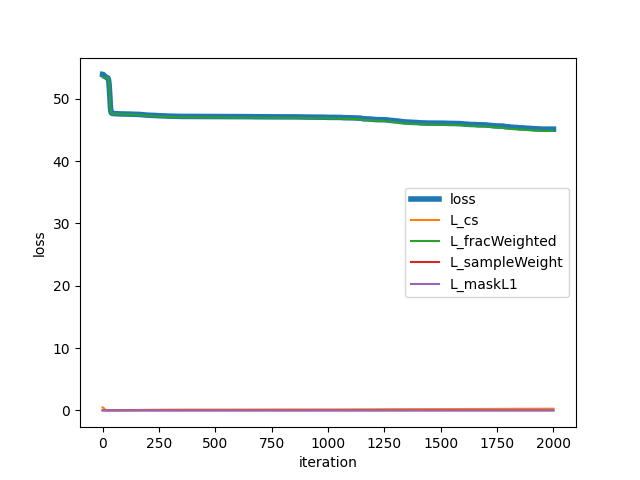

In [164]:
clusterAssigner.plot_loss()

In [194]:
gc.collect()

torch.cuda.empty_cache()

gc.collect()

torch.cuda.empty_cache()

<IPython.core.display.Javascript object>


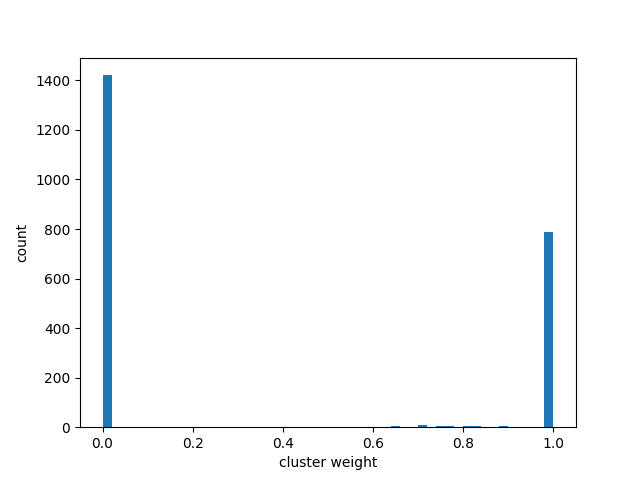

<IPython.core.display.Javascript object>


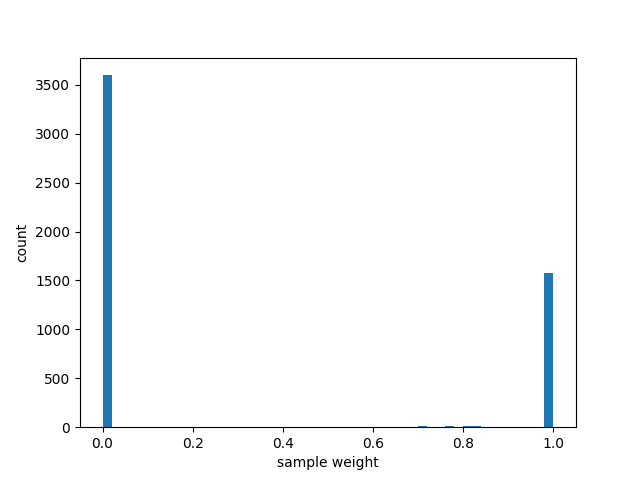

<IPython.core.display.Javascript object>


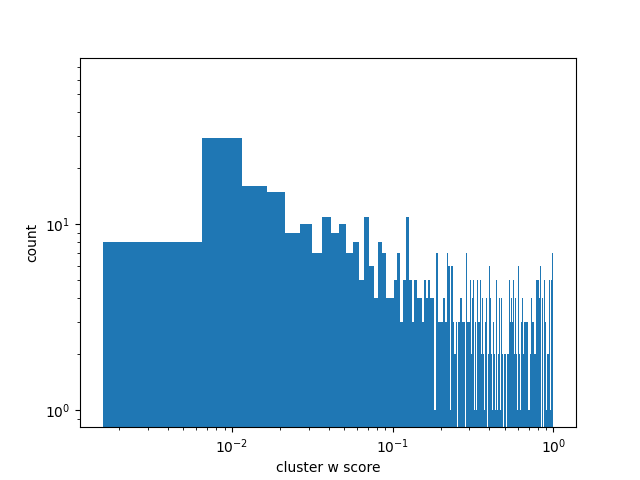

In [193]:
clusterAssigner.plot_clusterWeights()

clusterAssigner.plot_sampleWeights()

clusterAssigner.plot_clusterScores(bins=200)
plt.xscale('log')
plt.yscale('log')

[5249, 789]


<IPython.core.display.Javascript object>


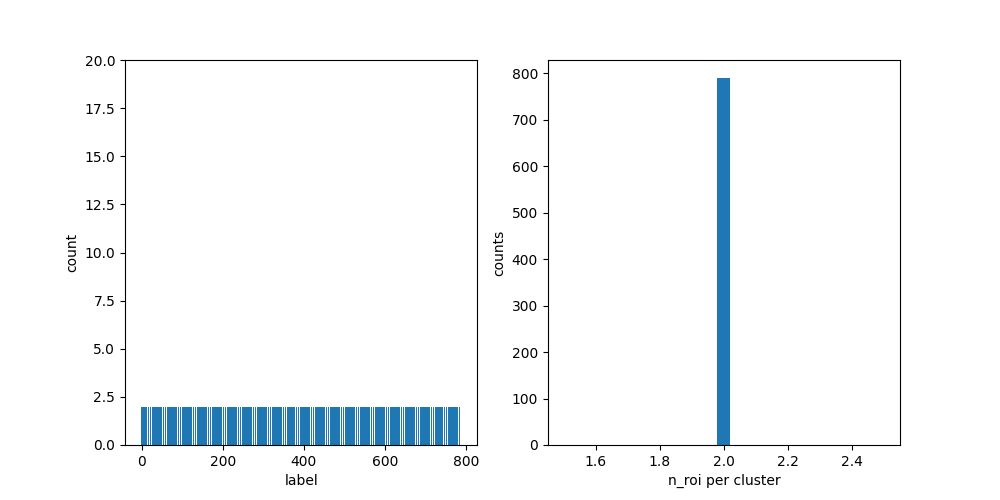

Number of clusters: 789


In [192]:
m_threshold=0.9

preds, confidence, scores_samples, m_bool = clusterAssigner.predict(m_threshold=m_threshold)

fig, axs = clusterAssigner.plot_labelCounts()
axs[0].set_ylim([0,20])

print(f'Number of clusters: {m_bool.sum()}')

<IPython.core.display.Javascript object>


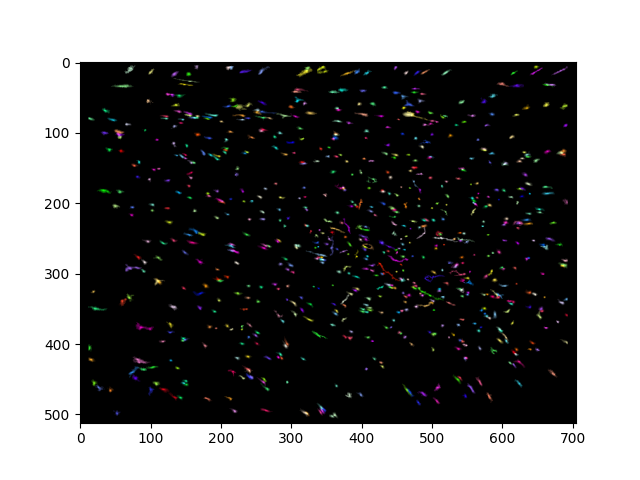

interactive(children=(IntSlider(value=0, description='i_frame', max=1), Output()), _dom_classes=('widget-inter…

In [190]:
FOV_clusters = visualization.compute_colored_FOV(
    spatialFootprints=aligner.ROIs_aligned,
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    preds=clusterAssigner.preds,
    confidence=clusterAssigner.confidence,
)

visualization.display_toggle_image_stack(FOV_clusters)

In [209]:
preds_by_session = [preds[idx].numpy() for idx in data.sessionID_concat.T]

ROIs = {
    "ROIs_aligned": aligner.ROIs_aligned,
    "ROIs_raw": data.spatialFootprints,
    "frame_height": data.FOV_height,
    "frame_width": data.FOV_width,
    "idx_roi_session": [np.where(idx)[0] for idx in data.sessionID_concat.T]
}

pickle_helpers.simple_save(
    {
        "UCIDs": list(clusterAssigner.preds.numpy().astype(np.int64)),
        "UCIDs_bySession": preds_bySession,
        "ROIs": ROIs,
    },
    filename=dir_save / (name_save + '.rClust' '.pkl'),
#     filename='/media/rich/bigSSD/analysis_data/mouse 2_6/multiday_alignment/UCIDs.pkl'
)